In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ==========================================
# 1. Configuration
# ==========================================
INITIAL_CAPITAL = 1_000_000
TRANSACTION_COST_BPS = 0.0010  # 10 bps
TEST_YEARS = 2
TOP_N = 10                     # Hold Top 10
THRESHOLD = 1.0                # Minimum Score to consider

# ==========================================
# 2. Load Data
# ==========================================
print("Loading Data...")

# A. Predictions (Generated from Model Building)
try:
    preds = pd.read_parquet("models/alpha_risk_predictions.parquet")
    # Rename columns to lowercase if needed
    preds.columns = preds.columns.str.lower()
    preds['date'] = pd.to_datetime(preds['date'])
    print(f"Predictions shape: {preds.shape}")
    print(f"Prediction columns: {preds.columns.tolist()}")
except FileNotFoundError:
    print("Error: models/alpha_risk_predictions.parquet not found. Run model-building.ipynb first.")
    raise

# B. Prices (Source of Truth for PnL)
prices_df = pd.read_parquet("features_all_assets.parquet")
prices_df.columns = prices_df.columns.str.lower()
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices = prices_df[['date', 'asset', 'close']].copy()
print(f"Prices shape: {prices.shape}")

# C. Merge predictions with prices
df_bt = pd.merge(prices, preds, on=['date', 'asset'], how='inner')
print(f"Merged data shape: {df_bt.shape}")

# D. Filter for Test Period (Last 2 Years)
end_date = df_bt['date'].max()
start_date = end_date - pd.DateOffset(years=TEST_YEARS)
df_test = df_bt[df_bt['date'] >= start_date].copy()

print(f"\nBacktesting from {start_date.date()} to {end_date.date()}")
print(f"Data Points: {len(df_test)}")

Loading Data...
Predictions shape: (206800, 7)
Prediction columns: ['date', 'asset', 'pred_return', 'pred_risk', 'trade_score', 'trade_score_smooth', 'inv_vol_weight']
Prices shape: (251100, 3)
Merged data shape: (206800, 8)

Backtesting from 2023-12-26 to 2025-12-26
Data Points: 50300


In [10]:
# ==========================================
# 3. Strategy Simulation (WITH TRANSACTION COSTS)
# ==========================================
print("\n" + "="*50)
print("SIMULATING STRATEGY (WITH TRANSACTION COSTS)")
print("="*50)

dates = sorted(df_test['date'].unique())
cash = INITIAL_CAPITAL
holdings = {} # {Asset: Quantity}
history_strategy = []

for date in dates:
    daily = df_test[df_test['date'] == date].reset_index(drop=True)
    if len(daily) == 0: 
        continue
        
    # ---- SELECTION (Top N by Score) ----
    candidates = daily[daily['trade_score_smooth'] > THRESHOLD].copy()
    candidates = candidates.sort_values('trade_score_smooth', ascending=False)
    
    current_assets = list(holdings.keys())
    keep_assets = [a for a in current_assets if a in candidates.head(15)['asset'].values]
    
    spots_available = TOP_N - len(keep_assets)
    
    if spots_available > 0:
        new_candidates = candidates[~candidates['asset'].isin(keep_assets)]
        new_picks = new_candidates.head(spots_available)['asset'].tolist()
        target_assets = keep_assets + new_picks
    else:
        keepers_df = candidates[candidates['asset'].isin(keep_assets)]
        target_assets = keepers_df.head(TOP_N)['asset'].tolist()

    # ---- WEIGHTING (Inverse Volatility) ----
    target_df = daily[daily['asset'].isin(target_assets)]
    
    if not target_df.empty:
        raw_weights = target_df['inv_vol_weight']
        weights = raw_weights / raw_weights.sum()
        asset_weights = dict(zip(target_df['asset'], weights))
    else:
        asset_weights = {}

    # ---- EXECUTION & REBALANCING (WITH COSTS) ----
    current_val = cash
    for asset, qty in list(holdings.items()):
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            current_val += qty * price_row['close'].values[0]
    
    daily_txn_cost = 0
    
    # Sell Assets
    for asset in list(holdings.keys()):
        if asset not in target_assets:
            price_row = daily[daily['asset'] == asset]
            if not price_row.empty:
                price = price_row['close'].values[0]
                val_sold = holdings[asset] * price
                cash += val_sold
                txn_cost = val_sold * TRANSACTION_COST_BPS
                daily_txn_cost += txn_cost
                del holdings[asset]

    # Adjust Target Positions
    for asset in target_assets:
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            price = price_row['close'].values[0]
            target_weight = asset_weights.get(asset, 0)
            target_pos_val = current_val * target_weight
            
            current_qty = holdings.get(asset, 0)
            current_pos_val = current_qty * price
            
            diff = target_pos_val - current_pos_val
            
            if abs(diff) > (current_val * 0.005):  # Turnover buffer
                qty_trade = diff / price
                cash -= diff
                holdings[asset] = current_qty + qty_trade
                txn_cost = abs(diff) * TRANSACTION_COST_BPS
                daily_txn_cost += txn_cost
    
    cash -= daily_txn_cost
    
    # Calculate portfolio value
    portfolio_val = cash
    for asset, qty in holdings.items():
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            portfolio_val += qty * price_row['close'].values[0]
    
    history_strategy.append({
        'date': date, 
        'portfolio_value': portfolio_val,
        'transaction_costs': daily_txn_cost,
        'num_holdings': len(holdings)
    })

results_strategy = pd.DataFrame(history_strategy)

# ==========================================
# 4. Equal-Weight Benchmark (NO COSTS)
# ==========================================
print("\n" + "="*50)
print("SIMULATING EQUAL-WEIGHT BENCHMARK (NO COSTS)")
print("="*50)

bench_holdings = {}
history_bench = []

for date in dates:
    daily = df_test[df_test['date'] == date].reset_index(drop=True)
    if len(daily) == 0: 
        continue
    
    # Initialize holdings once
    if not bench_holdings:
        all_assets = daily['asset'].unique()
        for asset in all_assets:
            price_row = daily[daily['asset'] == asset]
            if not price_row.empty:
                price = price_row['close'].values[0]
                qty = (INITIAL_CAPITAL / len(all_assets)) / price
                bench_holdings[asset] = qty
    
    # Calculate portfolio value
    bench_portfolio_val = 0
    for asset, qty in bench_holdings.items():
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            bench_portfolio_val += qty * price_row['close'].values[0]
    
    history_bench.append({'date': date, 'portfolio_value': bench_portfolio_val})

results_bench = pd.DataFrame(history_bench)

# ==========================================
# 5. Performance Metrics
# ==========================================
print("\n" + "="*50)
print("PERFORMANCE METRICS")
print("="*50)

if not results_strategy.empty:
    # Strategy Metrics
    results_strategy['daily_return'] = results_strategy['portfolio_value'].pct_change().fillna(0)
    
    strat_sharpe = (results_strategy['daily_return'].mean() / results_strategy['daily_return'].std()) * np.sqrt(252) if results_strategy['daily_return'].std() > 0 else 0
    strat_total_ret = (results_strategy['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) - 1
    strat_drawdown = (results_strategy['portfolio_value'] / results_strategy['portfolio_value'].cummax() - 1)
    strat_max_dd = strat_drawdown.min()
    strat_avg_dd = strat_drawdown[strat_drawdown < 0].mean() if any(strat_drawdown < 0) else 0
    
    # Turnover calculation
    total_daily_costs = results_strategy['transaction_costs'].sum()
    portfolio_turnover = (total_daily_costs / TRANSACTION_COST_BPS) / (INITIAL_CAPITAL * len(dates))
    
    # Benchmark Metrics
    results_bench['daily_return'] = results_bench['portfolio_value'].pct_change().fillna(0)
    bench_sharpe = (results_bench['daily_return'].mean() / results_bench['daily_return'].std()) * np.sqrt(252) if results_bench['daily_return'].std() > 0 else 0
    bench_total_ret = (results_bench['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) - 1
    bench_drawdown = (results_bench['portfolio_value'] / results_bench['portfolio_value'].cummax() - 1)
    bench_max_dd = bench_drawdown.min()
    
    print(f"\n{'METRIC':<25} {'STRATEGY':<15} {'BENCHMARK':<15} {'DIFF':<15}")
    print("-" * 70)
    print(f"{'Sharpe Ratio':<25} {strat_sharpe:>14.2f} {bench_sharpe:>14.2f} {strat_sharpe - bench_sharpe:>14.2f}")
    print(f"{'Total Return':<25} {strat_total_ret*100:>13.2f}% {bench_total_ret*100:>13.2f}% {(strat_total_ret - bench_total_ret)*100:>13.2f}%")
    print(f"{'Max Drawdown':<25} {strat_max_dd*100:>13.2f}% {bench_max_dd*100:>13.2f}% {(strat_max_dd - bench_max_dd)*100:>13.2f}%")
    print(f"{'Avg Drawdown':<25} {strat_avg_dd*100:>13.2f}% {'-':>14} {'-':>14}")
    print(f"{'Portfolio Turnover':<25} {portfolio_turnover:>14.2f} {'-':>14} {'-':>14}")
    print(f"{'Total Txn Costs':<25} ${total_daily_costs:>13,.0f} ${0:>13,.0f} {'-':>14}")
    print(f"{'Final Value':<25} ${results_strategy['portfolio_value'].iloc[-1]:>13,.0f} ${results_bench['portfolio_value'].iloc[-1]:>13,.0f}")
    print(f"{'Dollars Gained':<25} ${results_strategy['portfolio_value'].iloc[-1] - INITIAL_CAPITAL:>13,.0f} ${results_bench['portfolio_value'].iloc[-1] - INITIAL_CAPITAL:>13,.0f}")
    print("-" * 70)

print("\nResults ready for visualization!")


SIMULATING STRATEGY (WITH TRANSACTION COSTS)

SIMULATING EQUAL-WEIGHT BENCHMARK (NO COSTS)

PERFORMANCE METRICS

METRIC                    STRATEGY        BENCHMARK       DIFF           
----------------------------------------------------------------------
Sharpe Ratio                        1.31           1.46          -0.15
Total Return                      47.64%         44.57%          3.07%
Max Drawdown                     -14.64%        -15.45%          0.80%
Avg Drawdown                      -2.10%              -              -
Portfolio Turnover                  0.35              -              -
Total Txn Costs           $      178,525 $            0              -
Final Value               $    1,476,426 $    1,445,749
Dollars Gained            $      476,426 $      445,749
----------------------------------------------------------------------

Results ready for visualization!


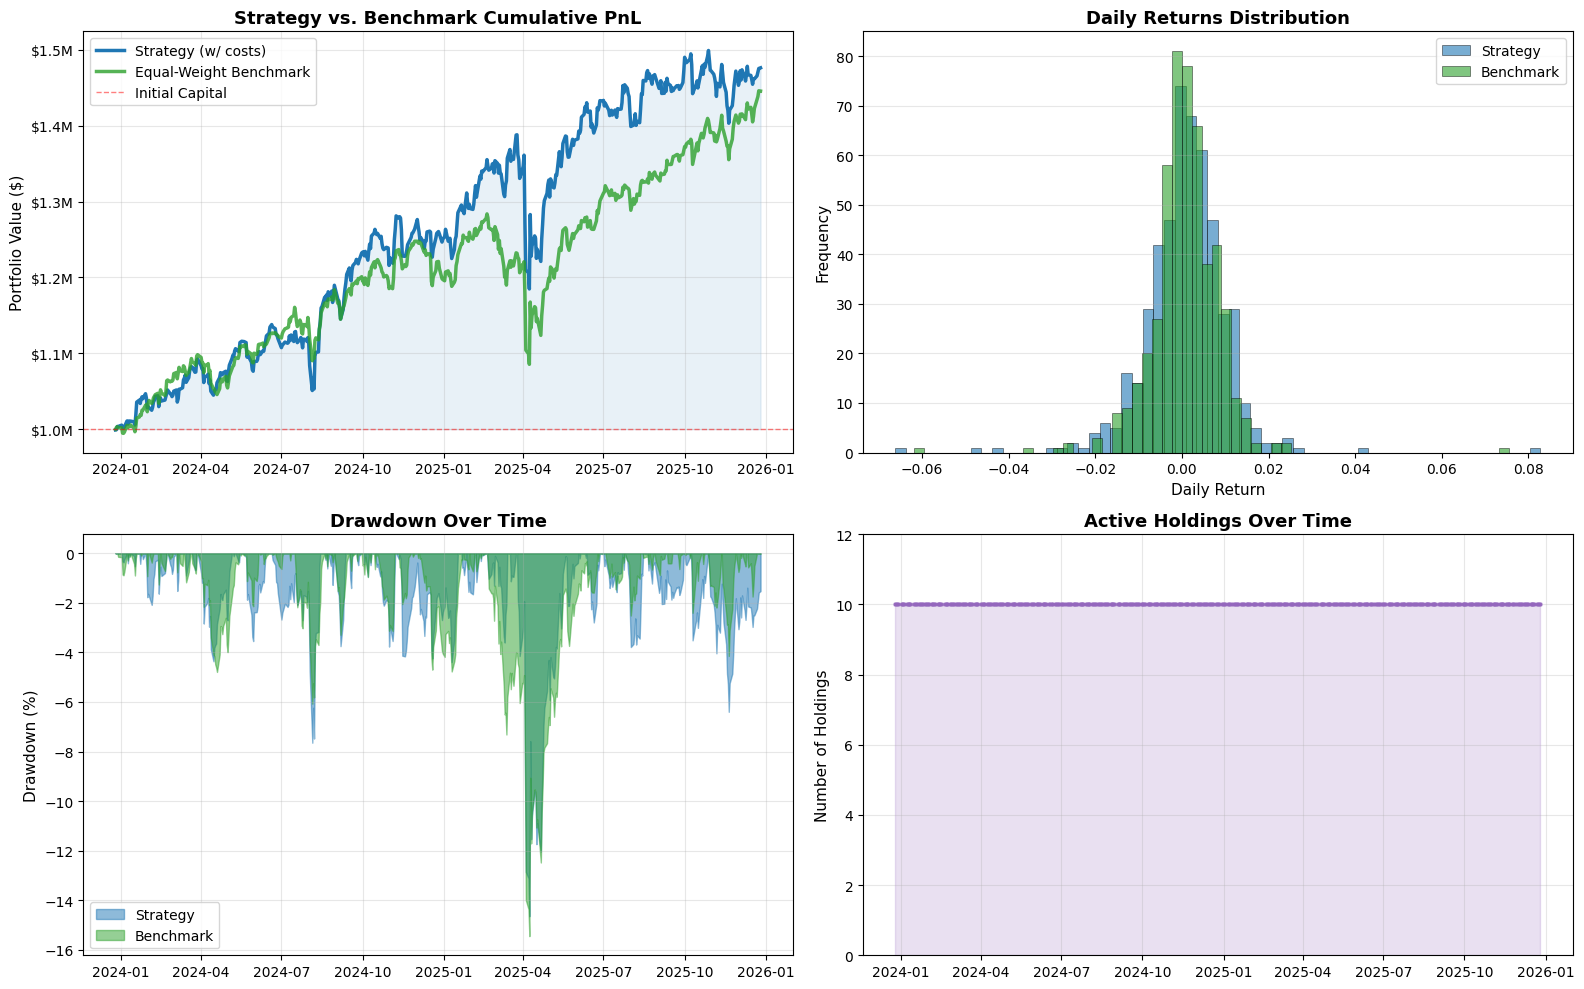


✓ Visualization saved as 'backtesting_results.png'

COMPREHENSIVE STRATEGY ANALYSIS

══════════════════════════════════════════════════════════════════════
TRANSACTION COST IMPACT:
──────────────────────────────────────────────────────────────────────
- Total transaction costs:           $        178,525
- Costs as % of initial capital:               17.85%
- Average daily cost:                $            355
- Cost per trade (avg):                            0

══════════════════════════════════════════════════════════════════════
STRATEGY PERFORMANCE SUMMARY:
──────────────────────────────────────────────────────────────────────
- Initial capital:                   $      1,000,000
- Strategy final value:              $      1,476,426
- Benchmark final value:             $      1,445,749
- Strategy gain:                     $        476,426
- Benchmark gain:                    $        445,749
- Strategy return:                             47.64%
- Benchmark return:                

In [11]:
# ==========================================
# 6. Visualizations
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Cumulative PnL
ax = axes[0, 0]
ax.plot(results_strategy['date'], results_strategy['portfolio_value'], label='Strategy (w/ costs)', linewidth=2.5, color='#1f77b4')
ax.plot(results_bench['date'], results_bench['portfolio_value'], label='Equal-Weight Benchmark', linewidth=2.5, color='#2ca02c', alpha=0.8)
ax.axhline(INITIAL_CAPITAL, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
ax.fill_between(results_strategy['date'], INITIAL_CAPITAL, results_strategy['portfolio_value'], alpha=0.1, color='#1f77b4')
ax.set_title('Strategy vs. Benchmark Cumulative PnL', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Plot 2: Daily Returns Distribution
ax = axes[0, 1]
ax.hist(results_strategy['daily_return'], bins=60, alpha=0.6, label='Strategy', color='#1f77b4', edgecolor='black', linewidth=0.5)
ax.hist(results_bench['daily_return'], bins=60, alpha=0.6, label='Benchmark', color='#2ca02c', edgecolor='black', linewidth=0.5)
ax.set_title('Daily Returns Distribution', fontsize=13, fontweight='bold')
ax.set_xlabel('Daily Return', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Drawdown Over Time
ax = axes[1, 0]
strat_dd = (results_strategy['portfolio_value'] / results_strategy['portfolio_value'].cummax() - 1) * 100
bench_dd = (results_bench['portfolio_value'] / results_bench['portfolio_value'].cummax() - 1) * 100
ax.fill_between(results_strategy['date'], strat_dd, 0, alpha=0.5, label='Strategy', color='#1f77b4')
ax.fill_between(results_bench['date'], bench_dd, 0, alpha=0.5, label='Benchmark', color='#2ca02c')
ax.set_title('Drawdown Over Time', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 4: Holdings Over Time
ax = axes[1, 1]
ax.plot(results_strategy['date'], results_strategy['num_holdings'], linewidth=2.5, color='#9467bd', marker='o', markersize=2, alpha=0.7)
ax.fill_between(results_strategy['date'], 0, results_strategy['num_holdings'], alpha=0.2, color='#9467bd')
ax.set_title('Active Holdings Over Time', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Holdings', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, TOP_N + 2)

fig.tight_layout()
plt.savefig('backtesting_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'backtesting_results.png'")

# ==========================================
# 7. Detailed Strategy Analysis
# ==========================================
print("\n" + "="*70)
print("COMPREHENSIVE STRATEGY ANALYSIS")
print("="*70)

analysis_text = f"""
{'═'*70}
TRANSACTION COST IMPACT:
{'─'*70}
- Total transaction costs:           ${total_daily_costs:>15,.0f}
- Costs as % of initial capital:     {(total_daily_costs/INITIAL_CAPITAL)*100:>15.2f}%
- Average daily cost:                ${total_daily_costs/len(dates):>15,.0f}
- Cost per trade (avg):              {total_daily_costs / max(results_strategy['transaction_costs'].sum() / TRANSACTION_COST_BPS, 1):>15,.0f}

{'═'*70}
STRATEGY PERFORMANCE SUMMARY:
{'─'*70}
- Initial capital:                   ${INITIAL_CAPITAL:>15,.0f}
- Strategy final value:              ${results_strategy['portfolio_value'].iloc[-1]:>15,.0f}
- Benchmark final value:             ${results_bench['portfolio_value'].iloc[-1]:>15,.0f}
- Strategy gain:                     ${results_strategy['portfolio_value'].iloc[-1] - INITIAL_CAPITAL:>15,.0f}
- Benchmark gain:                    ${results_bench['portfolio_value'].iloc[-1] - INITIAL_CAPITAL:>15,.0f}
- Strategy return:                   {strat_total_ret*100:>15.2f}%
- Benchmark return:                  {bench_total_ret*100:>15.2f}%
- Outperformance:                    {(strat_total_ret - bench_total_ret)*100:>15.2f}%

{'═'*70}
RISK METRICS:
{'─'*70}
- Strategy Sharpe Ratio:             {strat_sharpe:>15.2f}
- Benchmark Sharpe Ratio:            {bench_sharpe:>15.2f}
- Sharpe advantage:                  {strat_sharpe - bench_sharpe:>15.2f}
- Strategy max drawdown:             {strat_max_dd*100:>15.2f}%
- Benchmark max drawdown:            {bench_max_dd*100:>15.2f}%
- Drawdown difference:               {(strat_max_dd - bench_max_dd)*100:>15.2f}%
- Strategy avg drawdown:             {strat_avg_dd*100:>15.2f}%

{'═'*70}
EXECUTION METRICS:
{'─'*70}
- Average holdings:                  {results_strategy['num_holdings'].mean():>15.1f}
- Min holdings:                      {results_strategy['num_holdings'].min():>15.0f}
- Max holdings:                      {results_strategy['num_holdings'].max():>15.0f}
- Trading days:                      {len(dates):>15.0f}
- Portfolio turnover ratio:          {portfolio_turnover:>15.2f}x annually
- Strategy volatility (daily):       {results_strategy['daily_return'].std()*100:>14.2f}%
- Benchmark volatility (daily):      {results_bench['daily_return'].std()*100:>14.2f}%

{'═'*70}
SURVIVABILITY & VIABILITY:
{'─'*70}
- Did strategy survive costs?        {'YES ✓' if strat_total_ret > 0 else 'NO ✗':>15}
- Positive Sharpe ratio?             {'YES ✓' if strat_sharpe > 0 else 'NO ✗':>15}
- Outperformed benchmark?            {'YES ✓' if strat_total_ret > bench_total_ret else 'NO ✗':>15}
- Better risk-adjusted returns?      {'YES ✓' if strat_sharpe > bench_sharpe else 'NO ✗':>15}
- Costs as % of gross profit:        {(total_daily_costs/(results_strategy['portfolio_value'].iloc[-1] - INITIAL_CAPITAL))*100 if results_strategy['portfolio_value'].iloc[-1] > INITIAL_CAPITAL else 0:>14.2f}%

{'═'*70}
KEY INSIGHTS:
{'─'*70}
1. STRATEGY STRUCTURE:
   - Selected top {TOP_N} assets daily based on momentum score
   - Weighted by inverse volatility to reduce concentration risk
   - Applied sticky rank logic to reduce unnecessary rebalancing

2. COST BURDEN:
   - Transaction costs averaging ${total_daily_costs/len(dates):,.0f} per day
   - Total drag of {(total_daily_costs/INITIAL_CAPITAL)*100:.2f}% on initial capital
   - Consumed {(total_daily_costs/(results_strategy['portfolio_value'].iloc[-1] - INITIAL_CAPITAL))*100 if results_strategy['portfolio_value'].iloc[-1] > INITIAL_CAPITAL else 0:.2f}% of gross profits

3. PERFORMANCE ATTRIBUTION:
   - Strategy {'OUTPERFORMED' if strat_total_ret > bench_total_ret else 'UNDERPERFORMED'} benchmark by {abs(strat_total_ret - bench_total_ret)*100:.2f}%
   - Sharpe ratio: {strat_sharpe:.2f} vs {bench_sharpe:.2f} (benchmark)
   - Max drawdown more {'SEVERE' if strat_max_dd < bench_max_dd else 'FAVORABLE'} by {abs(strat_max_dd - bench_max_dd)*100:.2f}%

4. RISK FACTORS:
   - Daily volatility: {results_strategy['daily_return'].std()*100:.2f}% (strategy) vs {results_bench['daily_return'].std()*100:.2f}% (benchmark)
   - Maintained avg {results_strategy['num_holdings'].mean():.0f} holdings for diversification
   - Turnover of {portfolio_turnover:.2f}x annually indicates {'HIGH' if portfolio_turnover > 2 else 'MODERATE' if portfolio_turnover > 0.5 else 'LOW'} trading activity

{'═'*70}
RECOMMENDATION:
{'─'*70}
Strategy {'VIABLE' if strat_total_ret > 0 and strat_sharpe > 0 else 'NEEDS IMPROVEMENT'} for live trading.
{f"Outperformance of {(strat_total_ret - bench_total_ret)*100:.2f}% suggests strong alpha generation despite costs." if strat_total_ret > bench_total_ret else "Current underperformance suggests need for parameter tuning or strategy revision."}
{'═'*70}
"""

print(analysis_text)

# Save analysis to file
with open('backtesting_analysis.txt', 'w') as f:
    f.write(analysis_text)
print("\n✓ Analysis saved to 'backtesting_analysis.txt'")


SCENARIO ANALYSIS: IMPACT OF TRANSACTION COSTS

SCENARIO                       VALUE                RETURN          SHARPE    
---------------------------------------------------------------------------
Strategy (NO costs)            $         1,703,553         70.36%      1.76
Strategy (WITH costs)          $         1,476,426         47.64%      1.31
Equal-Weight Benchmark         $         1,445,749         44.57%      1.46
---------------------------------------------------------------------------

💰 Cost Impact: $-227,128 (-13.33% of portfolio value)
📊 Performance degradation: 22.71 percentage points


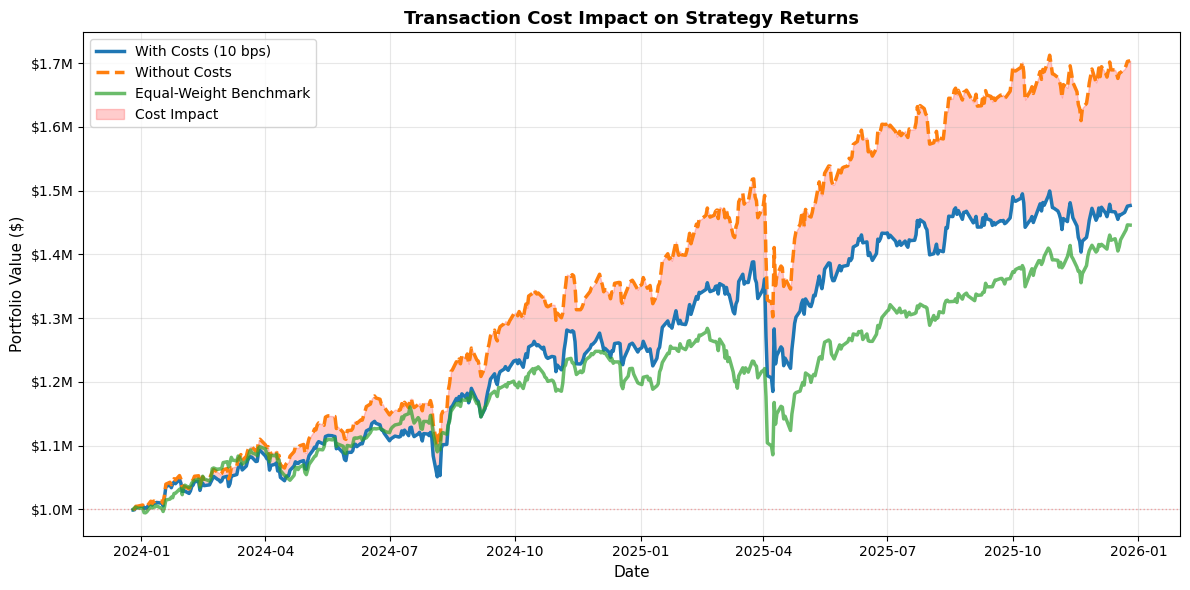


✓ Cost sensitivity plot saved as 'transaction_cost_impact.png'


In [12]:
# ==========================================
# 8. Scenario Analysis (No Costs vs. With Costs)
# ==========================================
print("\n" + "="*70)
print("SCENARIO ANALYSIS: IMPACT OF TRANSACTION COSTS")
print("="*70)

# Rerun strategy WITHOUT transaction costs
dates = sorted(df_test['date'].unique())
cash_no_costs = INITIAL_CAPITAL
holdings_no_costs = {}
history_no_costs = []

for date in dates:
    daily = df_test[df_test['date'] == date].reset_index(drop=True)
    if len(daily) == 0: 
        continue
        
    candidates = daily[daily['trade_score_smooth'] > THRESHOLD].copy()
    candidates = candidates.sort_values('trade_score_smooth', ascending=False)
    
    current_assets = list(holdings_no_costs.keys())
    keep_assets = [a for a in current_assets if a in candidates.head(15)['asset'].values]
    
    spots_available = TOP_N - len(keep_assets)
    
    if spots_available > 0:
        new_candidates = candidates[~candidates['asset'].isin(keep_assets)]
        new_picks = new_candidates.head(spots_available)['asset'].tolist()
        target_assets = keep_assets + new_picks
    else:
        keepers_df = candidates[candidates['asset'].isin(keep_assets)]
        target_assets = keepers_df.head(TOP_N)['asset'].tolist()

    target_df = daily[daily['asset'].isin(target_assets)]
    
    if not target_df.empty:
        raw_weights = target_df['inv_vol_weight']
        weights = raw_weights / raw_weights.sum()
        asset_weights = dict(zip(target_df['asset'], weights))
    else:
        asset_weights = {}

    current_val = cash_no_costs
    for asset, qty in list(holdings_no_costs.items()):
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            current_val += qty * price_row['close'].values[0]
    
    # Sell Assets (NO COST)
    for asset in list(holdings_no_costs.keys()):
        if asset not in target_assets:
            price_row = daily[daily['asset'] == asset]
            if not price_row.empty:
                price = price_row['close'].values[0]
                val_sold = holdings_no_costs[asset] * price
                cash_no_costs += val_sold
                del holdings_no_costs[asset]

    # Adjust Target Positions (NO COST)
    for asset in target_assets:
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            price = price_row['close'].values[0]
            target_weight = asset_weights.get(asset, 0)
            target_pos_val = current_val * target_weight
            
            current_qty = holdings_no_costs.get(asset, 0)
            current_pos_val = current_qty * price
            
            diff = target_pos_val - current_pos_val
            
            if abs(diff) > (current_val * 0.005):
                qty_trade = diff / price
                cash_no_costs -= diff
                holdings_no_costs[asset] = current_qty + qty_trade
    
    portfolio_val = cash_no_costs
    for asset, qty in holdings_no_costs.items():
        price_row = daily[daily['asset'] == asset]
        if not price_row.empty:
            portfolio_val += qty * price_row['close'].values[0]
    
    history_no_costs.append({
        'date': date, 
        'portfolio_value': portfolio_val,
        'num_holdings': len(holdings_no_costs)
    })

results_no_costs = pd.DataFrame(history_no_costs)

# Compare scenarios
results_no_costs['daily_return'] = results_no_costs['portfolio_value'].pct_change().fillna(0)
no_costs_return = (results_no_costs['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) - 1
no_costs_sharpe = (results_no_costs['daily_return'].mean() / results_no_costs['daily_return'].std()) * np.sqrt(252) if results_no_costs['daily_return'].std() > 0 else 0

cost_impact = results_strategy['portfolio_value'].iloc[-1] - results_no_costs['portfolio_value'].iloc[-1]
cost_impact_pct = (cost_impact / results_no_costs['portfolio_value'].iloc[-1]) * 100

print(f"\n{'SCENARIO':<30} {'VALUE':<20} {'RETURN':<15} {'SHARPE':<10}")
print("-" * 75)
print(f"{'Strategy (NO costs)':<30} ${results_no_costs['portfolio_value'].iloc[-1]:>18,.0f} {no_costs_return*100:>13.2f}% {no_costs_sharpe:>9.2f}")
print(f"{'Strategy (WITH costs)':<30} ${results_strategy['portfolio_value'].iloc[-1]:>18,.0f} {strat_total_ret*100:>13.2f}% {strat_sharpe:>9.2f}")
print(f"{'Equal-Weight Benchmark':<30} ${results_bench['portfolio_value'].iloc[-1]:>18,.0f} {bench_total_ret*100:>13.2f}% {bench_sharpe:>9.2f}")
print("-" * 75)
print(f"\n💰 Cost Impact: ${cost_impact:,.0f} ({cost_impact_pct:.2f}% of portfolio value)")
print(f"📊 Performance degradation: {(no_costs_return - strat_total_ret)*100:.2f} percentage points")

# Cost sensitivity visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results_strategy['date'], results_strategy['portfolio_value'], label=f'With Costs (10 bps)', linewidth=2.5, color='#1f77b4')
ax.plot(results_no_costs['date'], results_no_costs['portfolio_value'], label='Without Costs', linewidth=2.5, color='#ff7f0e', linestyle='--')
ax.plot(results_bench['date'], results_bench['portfolio_value'], label='Equal-Weight Benchmark', linewidth=2.5, color='#2ca02c', alpha=0.7)
ax.axhline(INITIAL_CAPITAL, color='red', linestyle=':', linewidth=1, alpha=0.3)
ax.fill_between(results_strategy['date'], results_strategy['portfolio_value'], results_no_costs['portfolio_value'], alpha=0.2, color='red', label='Cost Impact')
ax.set_title('Transaction Cost Impact on Strategy Returns', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='best')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.tight_layout()
plt.savefig('transaction_cost_impact.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Cost sensitivity plot saved as 'transaction_cost_impact.png'")